In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from scipy.optimize import minimize
from scipy.special import lambertw

In [3]:
from Spherical_integrals_T import *
from routines import *
from known_formulas import *

### Annealed vs RS

In [28]:
p = 3
n_points_m = 1_000
n_points_T = 4
n_points_more_T = 1

T_kauz, T_dyn = np.sqrt(3/8)- 0.05, np.sqrt(3/8)+ 0.05#get_Tk_Td(p)

Teqs = np.hstack((np.linspace(T_kauz, T_dyn, n_points_T), T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1)))
Teqs = 1/np.array([1.59, 1.63, 1.66, 1.7])
es = -1 / (2 * Teqs)

In [29]:
Teqs

array([0.62893082, 0.61349693, 0.60240964, 0.58823529])

In [30]:
file_path = f'./dataSph/rs_p{p:d}.pkl'
if False: #os.path.exists(file_path):
    print("Data is already saved.")

    with open(file_path, 'rb') as f:
        tmp = pickle.load(f)
        data = tmp['data']
        ms = tmp['ms']

    print("Data is loaded.")
else:
    print("Data is not saved.")

    ms = np.linspace(0.01, 0.95, n_points_m)
    data = observables_Sph((len(Teqs), n_points_m))
    
    for jdx, T in enumerate(tqdm(Teqs, desc='RS')):
        for idx, m in enumerate(ms):
            q = fixed_points_q(m, T, p)

            data['q'][jdx, idx] = q
            #data['delta_f'][jdx, idx] = deltaf_FP(m, q, h, p, e)
            data['s'][jdx, idx] = s_FP(q, m, 0, p, T)
            data['f'][jdx, idx] = f_FP(q, m, 0, p, T)
            #data['dAT'][jdx, idx] = dAT_condition(
            #    q, m, h, beta_q_e(q, m, e, p,h), beta_q_e(q, m, e, p,h) / 2, p
            #)

    with open(f'./dataSph/rs_p{p:d}.pkl', 'wb') as f:
        pickle.dump({'data': data, 'ms': ms}, f)

    print("Data is saved.")

Data is not saved.


RS:   0%|          | 0/4 [00:00<?, ?it/s]

Data is saved.


In [60]:
s_anneald = np.empty((len(Teqs), len(ms)))
for jdx, e in enumerate(tqdm(es, desc="Annealed")):
    for idx, m in enumerate(ms):
        s_anneald[jdx, idx] = annealed_entropy(m, e, p)

Annealed:   0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'annealed_entropy' is not defined

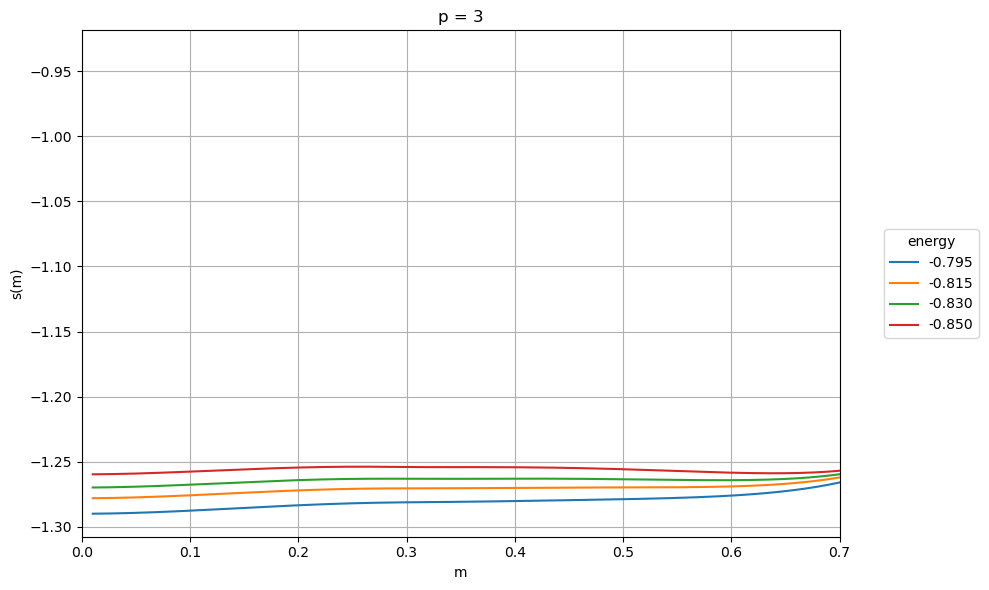

In [31]:
plt.figure(figsize=(10,6))
plt.title(f"p = {p:d}")
for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    #plt.plot(ms, s_anneald[i], ':', color=f'C{i}')
    plt.plot(ms, data['f'][i], label=legend_name, color=f'C{i}')

plt.xlabel('m')
plt.ylabel(r's(m)')
lgd = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="energy")
plt.grid()
#plt.yscale('log')
plt.xlim(0, 0.7)
plt.tight_layout()
#plt.savefig(
#    f"./imgs/imgs_Sph/annealed_vs_RS_p{p:d}.png",
#    bbox_extra_artists=(lgd,),
#    bbox_inches="tight",
#    dpi=360,
#)

In [18]:
data["f"]

array([[-1.24248995, -1.24248468, -1.24247897, ..., -1.0176785 ,
        -1.01337558, -1.00897115],
       [-1.26491119, -1.26490558, -1.26489949, ..., -0.97961692,
        -0.97495029, -0.97017673],
       [-1.28996874, -1.28996278, -1.28995632, ..., -0.94642675,
        -0.94140605, -0.93627298],
       [-1.31726457, -1.31725828, -1.31725144, ..., -0.91738891,
        -0.91202202, -0.90653733],
       [-1.33900944, -1.33900289, -1.33899578, ..., -0.89798017,
        -0.89235799, -0.88661391]])

### Compute $e_{\rm sh}$ from first moment

#### Check

In [9]:
p = 4
n_points_m = 1_000
n_points_T = 10

Teqs = np.linspace(0.61 ,2, n_points_T)
es = -1 / (2 * Teqs)
ms = np.linspace(0.0, 0.999, n_points_m)

In [10]:
s_anneald = np.empty((len(Teqs), len(ms)))
for jdx, e in enumerate(tqdm(es, desc="Annealed")):
    for idx, m in enumerate(ms):
        s_anneald[jdx, idx] = annealed_entropy(m, e, p)

Annealed:   0%|          | 0/10 [00:00<?, ?it/s]

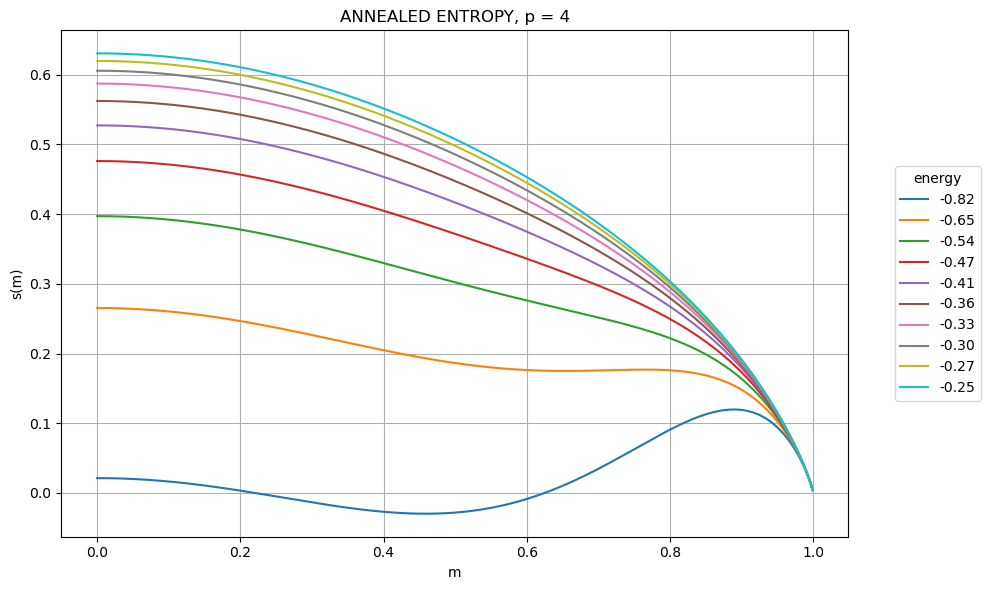

In [11]:
plt.figure(figsize=(10,6))
plt.title(f"ANNEALED ENTROPY, p = {p:d}")
for i, e in enumerate(es):
    plt.plot(ms, s_anneald[i], color=f'C{i}', label=f'{es[i]:.2f}')

plt.xlabel('m')
plt.ylabel(r's(m)')
lgd = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="energy")
plt.grid()
#plt.xlim(0.95, 1)
#plt.ylim(-0.05, 0.1)

plt.tight_layout()

#### Computation

In [315]:
n_points_m = 50_000

In [316]:
def find_minimum_entropy(e, p, n_points_m):
    ms = np.linspace(1e-6, 1-1e-6, n_points_m)
    ders = np.array([deriv_ann_entropy(m, e, p) for m in ms])
    if deriv_ann_entropy(ms[np.argmin(ders)], e, p) > 0:
        m_min = 0.
    else:
        m_min = root_scalar(deriv_ann_entropy, args=(e, p), bracket=[1/n_points_m, ms[np.argmin(ders)]]).root
    return annealed_entropy(m_min, e, p)

In [340]:
np.unique(np.logspace(0.5,4,500,dtype=int))[230]

993

In [320]:
ps = np.unique(np.logspace(0.5,4,500,dtype=int))
ess = np.empty(len(ps))
for i,p in enumerate(tqdm(ps)):
    if (p==3): 
        ess[i] = root_scalar(find_minimum_entropy, args=(p, n_points_m), bracket=[-0.9, 0]).root
    else: 
        ess[i] = root_scalar(find_minimum_entropy, args=(p, n_points_m), bracket=[-0.81, 0]).root

  0%|          | 0/374 [00:00<?, ?it/s]

In [344]:
a,b = np.polyfit(np.log(1/ps[300:]), np.log(-ess[300:]), 1)

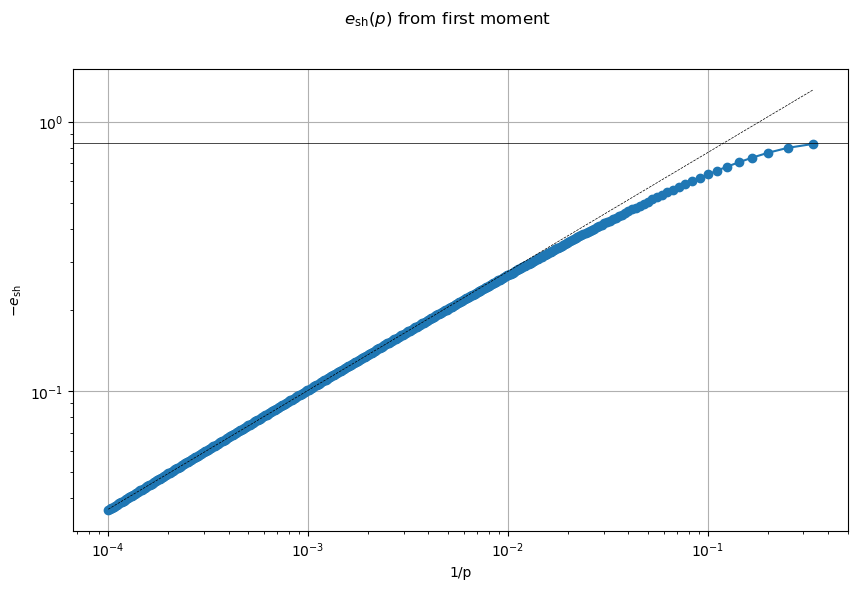

In [332]:
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"$e_{\rm sh}(p)$ from first moment")
ax.plot(1/ps, -ess, '-o')
ax.axhline(np.sqrt(np.log(2)), color='black', lw=0.5)
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '--', color='black', lw=0.5)
ax.set_xlabel('1/p')
ax.set_ylabel(r'$-e_{\rm sh}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()

In [333]:
a,b

(0.44188224583162694, 0.7553026998284301)

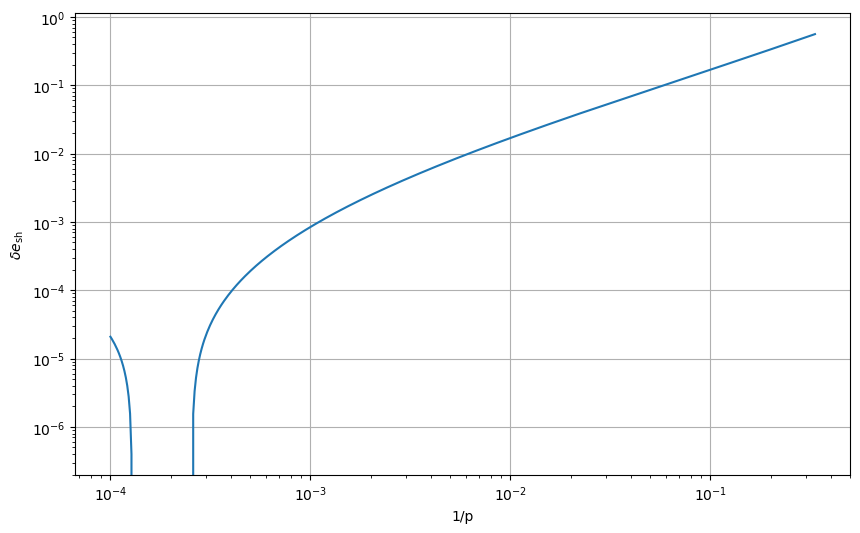

In [349]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.suptitle(r"$\delta e_{\rm sh}(p)$")
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a)+ess, '-')
ax.set_xlabel('1/p')
ax.set_ylabel(r'$\delta e_{\rm sh}$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_yscale('symlog', linthresh=1e-5)
ax.grid()

#### Superimpose with Td from Franz-Parisi

In [128]:
#ps = np.arange(3,1003)
ps = np.unique(np.logspace(2,6,500,dtype=int))
Tds = np.empty(len(ps))
for idx, p in enumerate(tqdm(ps)):
    Tds[idx] = compute_Td_standard(p)

  0%|          | 0/500 [00:00<?, ?it/s]

In [129]:
#a_d,b_d = np.polyfit(np.log(1/ps[300:]), np.log(0.5/Tds[300:]), 1)
a_d,b_d = np.polyfit(np.log(ps[400:]), np.log(1/Tds[400:]), 1)

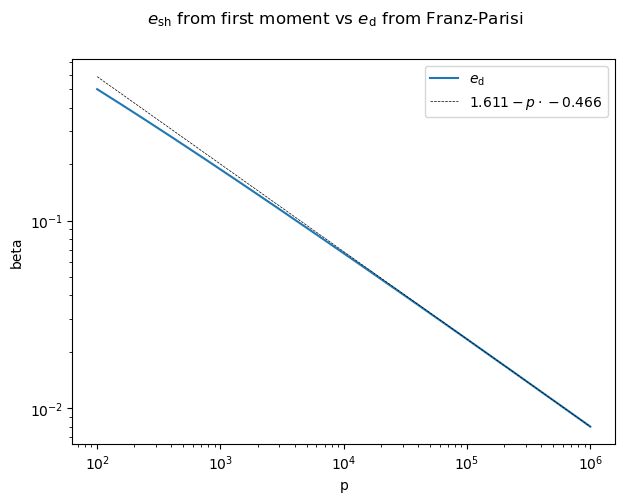

In [130]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle(r"$e_{\rm sh}$ from first moment vs $e_{\rm d}$ from Franz-Parisi")
#ax.plot(1/ps, -ess, '-', label=r'$e_{\rm sh}$')
ax.plot(ps, 1/Tds, '-', label=r'$e_{\rm d}$')
ax.plot(ps, np.exp(b_d)*np.power(ps, a_d), '--', color='black', lw=0.5, label=f'${b_d:.3f} - p \cdot {a_d:.3f}$')
#ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '-.', color='black', lw=0.5, label=f'${b:.3f} - p \cdot {a:.3f}$')
ax.set_xlabel('p')
ax.set_ylabel('beta')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

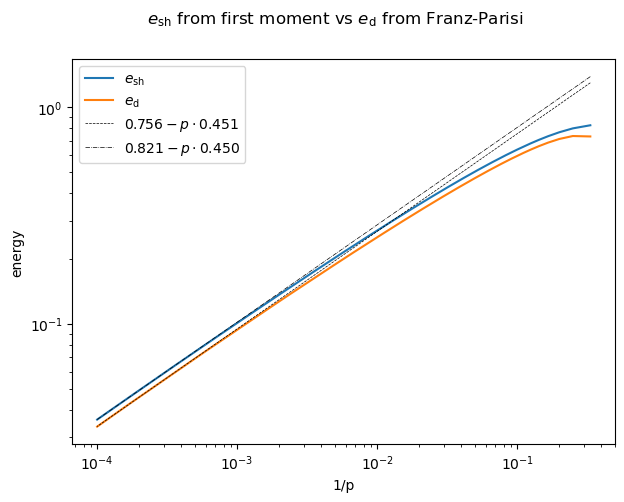

In [346]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle(r"$e_{\rm sh}$ from first moment vs $e_{\rm d}$ from Franz-Parisi")
ax.plot(1/ps, -ess, '-', label=r'$e_{\rm sh}$')
ax.plot(1/ps, 0.5/Tds, '-', label=r'$e_{\rm d}$')
ax.plot(1/ps, np.exp(b_d)*np.power(1/ps, a_d), '--', color='black', lw=0.5, label=f'${b_d:.3f} - p \cdot {a_d:.3f}$')
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '-.', color='black', lw=0.5, label=f'${b:.3f} - p \cdot {a:.3f}$')
ax.set_xlabel('1/p')
ax.set_ylabel('energy')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'./imgs/esh_vs_ed_.png', dpi=360)

## m

In [125]:
#ps = np.arange(3,1003)
ps = np.unique(np.logspace(2,6,500,dtype=int))
ms = np.empty(len(ps))
for idx, p in enumerate(tqdm(ps)):
    ms[idx] = compute_m_atTd_standard(p)

  0%|          | 0/500 [00:00<?, ?it/s]

In [147]:
#a_d,b_d = np.polyfit(np.log(1/ps[300:]), np.log(0.5/Tds[300:]), 1)
a_d,b_d = np.polyfit(np.log(1/ps[400:]), np.log(1- ms[400:]), 1)

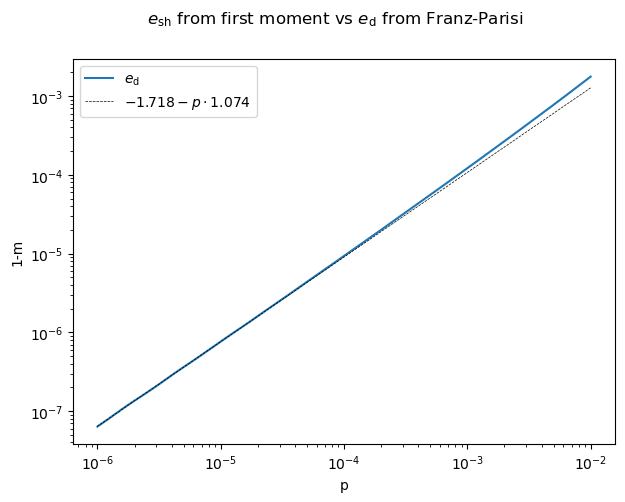

In [148]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle(r"$e_{\rm sh}$ from first moment vs $e_{\rm d}$ from Franz-Parisi")
#ax.plot(1/ps, -ess, '-', label=r'$e_{\rm sh}$')
ax.plot(1/ps, 1 - ms**(1), '-', label=r'$e_{\rm d}$')
ax.plot(1/ps, np.exp(b_d)*np.power(1/ps, a_d), '--', color='black', lw=0.5, label=f'${b_d:.3f} - p \cdot {a_d:.3f}$')
#ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '-.', color='black', lw=0.5, label=f'${b:.3f} - p \cdot {a:.3f}$')
ax.set_xlabel('p')
ax.set_ylabel('1-m')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle(r"$e_{\rm sh}$ from first moment vs $e_{\rm d}$ from Franz-Parisi")
#ax.plot(1/ps, -ess, '-', label=r'$e_{\rm sh}$')
ax.plot(1/ps, 1 - ms**(1), '-', label=r'$e_{\rm d}$')
ax.plot(1/ps, np.exp(b_d)*np.power(1/ps, a_d), '--', color='black', lw=0.5, label=f'${b_d:.3f} - p \cdot {a_d:.3f}$')
#ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '-.', color='black', lw=0.5, label=f'${b:.3f} - p \cdot {a:.3f}$')
ax.set_xlabel('p')
ax.set_ylabel('m**p')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

### first order correction

In [269]:
def m_first_order(x,a):
    return 2*np.exp(-2*(a*x + a*a)-x*x/2)/np.sqrt(2*np.pi)

def m_second_order(x,a):
    return 2*(-np.exp(-4*(a*x + a*a)-x*x/2)+np.exp(-2*(a*x + a*a)-x*x/2))/np.sqrt(2*np.pi)

def m_third_order(x,a):
    return 2*(np.exp(-6*(a*x + a*a)-x*x/2)-np.exp(-4*(a*x + a*a)-x*x/2)+np.exp(-2*(a*x + a*a)-x*x/2))/np.sqrt(2*np.pi)

def m_from_tanh(x,a):
    return (1-np.tanh(a*x+a*a))*np.exp(-x*x/2)/np.sqrt(2*np.pi)

def tanh(x,a):
    return np.tanh(a*x+a*a)

(1e-50, 100000.0)

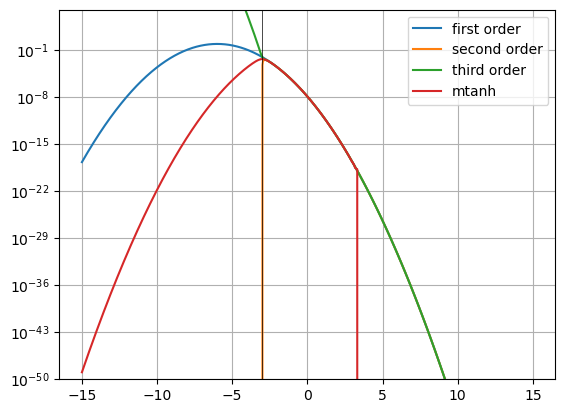

In [439]:
x = np.linspace(-15,15,1000)
a = 3
plt.plot(x, m_first_order(x,a),label='first order')
plt.plot(x, m_second_order(x,a),label='second order')
plt.plot(x, m_third_order(x,a),label='third order')
plt.plot(x, m_from_tanh(x,a),label='mtanh')
plt.axvline(-a, color='black', lw=0.5)
#plt.plot(x, tanh(x,a),label='tanh')
plt.legend()
plt.grid()
#plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-50,1e5)

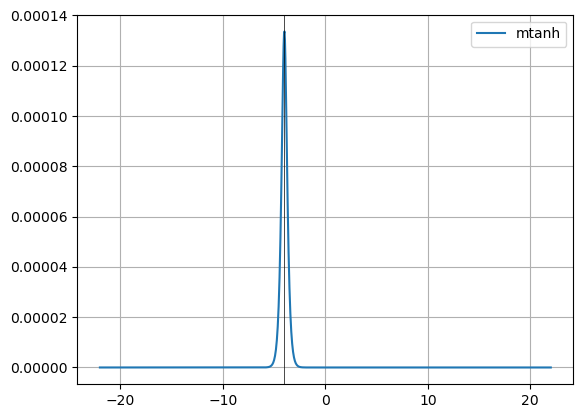

In [440]:
x = np.linspace(-22,22,1000)
a = 4
#plt.plot(x, m_first_order(x,a),label='first order')
plt.plot(x, m_from_tanh(x,a),label='mtanh')
plt.axvline(-a, color='black', lw=0.5)
#plt.plot(x, tanh(x,a),label='tanh')
plt.legend()
plt.grid()
#plt.xscale("log")
#plt.yscale("log")

In [298]:
int_first_order(13)

1.9310719911548715

In [209]:
np.exp(-2*13*13)

1.616088413820251e-147

In [313]:
a_tab=[2,10,12]
z_star = np.empty(len(a_tab))
for i,a in enumerate(a_tab):
    z_star[i] = (lambertw(-4*a*a*exp(-2*a*a),-1))/(2*a)

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_35799/3030161954.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  z_star[i] = (lambertw(-4*a*a*exp(-2*a*a),-1))/(2*a)


In [364]:
def z_star(a,damp):
    z = -2*a
    err = 1
    while err > 1e-10:
        z_new = -2*a*np.tanh(a*(z+a))
        err = np.abs(z_new-z)
        z = damp*z +(1-damp)*z_new
        print(z,z_new,err)
    return z

In [435]:
def f(x,a):
    return x + a +a*np.tanh(a*(a+x))

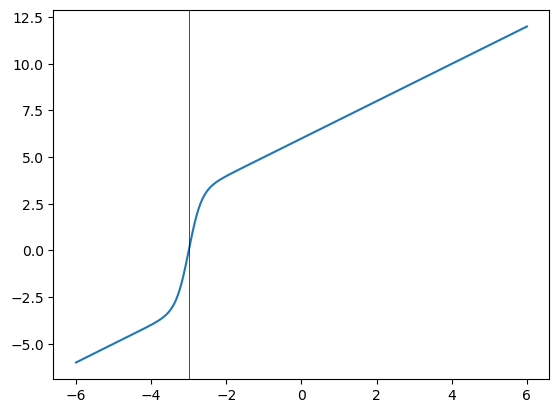

In [437]:
a = 3
x = np.linspace(-2*a,2*a,1000)
plt.plot(x, f(x,a),label='f')
#plt.plot(x, x,label='lin')
plt.axvline(-a, color='black', lw=0.5)
#plt.axvline((lambertw(-4*a*a*exp(-2*a*a),-1))/(2*a), color='red', lw=0.5)
#plt.ylim(-a*1.1,-a*0.9)
#plt.xlim(-a*1.1,-a*0.9);

In [429]:
a_tab = np.logspace(1,3,200)
z_s = np.empty(len(a_tab))

for i,a in enumerate(a_tab):
    z_s[i] = root_scalar(f, args=(a,), bracket=[-2*a, 2*a]).root

In [430]:
a_z,b_z = np.polyfit(np.log(a_tab), np.log(z_s + a_tab), 1)

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_35799/3987111013.py:1: RuntimeWarning: divide by zero encountered in log
  a_z,b_z = np.polyfit(np.log(a_tab), np.log(z_s + a_tab), 1)
/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_35799/3987111013.py:1: RuntimeWarning: invalid value encountered in log
  a_z,b_z = np.polyfit(np.log(a_tab), np.log(z_s + a_tab), 1)


In [407]:
a_z,b_z

(-0.9992531502033251, -0.6032737181183768)

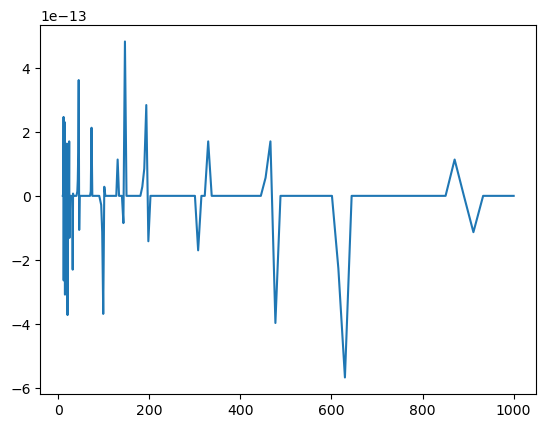

In [434]:
plt.plot(a_tab, z_s+a_tab, '-')
#plt.plot(a_tab, np.exp(b_z)*np.power(a_tab, a_z), '--', color='black', lw=0.5)
#plt.yscale('log')
#plt.xscale('log')

In [410]:
def f_eps(x,a):
    return a*a*(1-2*np.tanh(x))-x

In [423]:
a_tab = np.logspace(1,3,200)
eps_s = np.empty(len(a_tab))

for i,a in enumerate(a_tab):
    eps_s[i] = root_scalar(f_eps, args=(a,), bracket=[-2*a, 2*a]).root

In [424]:
eps_s[-1]

0.5493057781302699

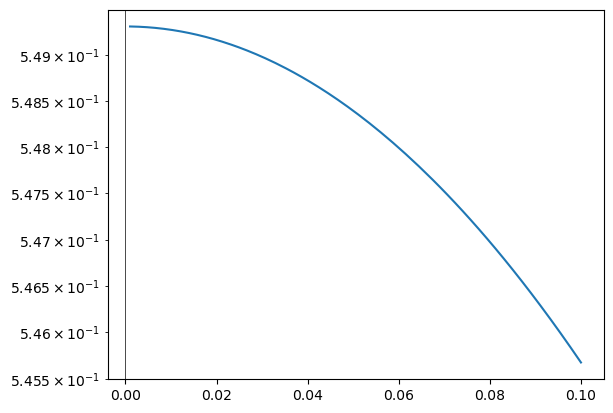

In [426]:
plt.plot(1/a_tab, eps_s, '-')
plt.yscale('log')
#plt.xscale('log')
plt.axvline(0, color='black', lw=0.5)